# DSCI 100 Project Individual Planning

In [1]:
# include libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(ggplot2)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## (1) Data Description

### Players Dataset
Overview
- Number of observations (rows): 196
- Number of variables (columns): 7
- played_hours might be from the Minecraft server, but all other data was most likely from their website where players enter their information

| Variable Name | Type | Description | Summary Statistics (to 2 decimals) | Notes / Issues |
| - | - | - | - | - |
| `experience` | Categorical | Player’s self-reported experience level (e.g., Amateur, Intermediate, Expert, etc.) | 5 unique values; most common: *Amateur* (63 players) | Could be ordinal but stored as text. |
| `subscribe` | Categorical | Whether the player subscribed to a game-related newsletter | 144 (True), 52 (False) | Fairly imbalanced — may bias models. |
| `hashedEmail` | String | Unique player identifier (hashed for privacy) | 196 unique values | Good for joining with `sessions.csv`. |
| `played_hours` | Numeric | Total number of hours each player spent in-game | Mean = 5.85, SD = 28.36, Min = 0.00, Median = 0.10, Max = 223.10 | Highly skewed — some extreme outliers. |
| `name` | String | Player’s name (pseudonymized) | 196 unique values | Not useful analytically. |
| `gender` | Categorical | Self-reported gender (Male, Female, Nonbinary, etc.) | 7 unique categories; most common: *Male* (124 players) | Possible inconsistencies or typos in text. |
| `Age` | Numeric | Player’s age in years | Mean = 21.14, SD = 7.39, Min = 9.00, Median = 19.00, Max = 58.00 | 2 missing values; wide age range. |

### Sessions Dataset
Overview
- Number of observations (rows): 1,535
- Number of variables (columns): 5
- Data was collected from the Minecraft server.

| Variable Name | Type | Description | Summary Statistics (to 2 decimals) | Notes / Issues |
| - | - | - | - | - |
| `hashedEmail` | String | Unique identifier matching players in `players.csv` | 125 unique IDs; most common appears 310 times | Used to link sessions to players. |
| `start_time` | String | Start timestamp of a game session (formatted date-time string) | 1,504 unique; most common = “28/06/2024 01:31” | Needs conversion to datetime. |
| `end_time` | String | End timestamp of a game session | 1,489 unique; 2 missing values | Needs conversion to datetime; missing values cause incomplete sessions. |
| `original_start_time` | Numeric | Original Unix timestamp of session start | Mean = 1.72×10¹², SD = 3.56×10⁹ | Likely milliseconds since epoch; can be converted to readable dates. |
| `original_end_time` | Numeric | Original Unix timestamp of session end | Mean = 1.72×10¹², SD = 3.55×10⁹ | 2 missing values; aligns with `end_time`. |


In [19]:
# load both datasets
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")
players
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [20]:
# summary of each dataset
summary(players)

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

In [21]:
summary(sessions)

 hashedEmail         start_time          end_time         original_start_time
 Length:1535        Length:1535        Length:1535        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time  
 Min.   :1.712e+12  
 1st Qu.:1.716e+12  
 Median :1.719e+12  
 Mean   :1.719e+12  
 3rd Qu.:1.722e+12  
 Max.   :1.727e+12  
 NA's   :2          

## (2) Questions

**Broad Question:**
What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific Question:**
Can player age and total play time predict whether a player subscribes to the newsletter?

#### How the observations will help the research group
The group will be able to advertise the project to specific demographics and design the advertisements accordingly using the data in order to attract testers more efficiently. 

#### Data Wrangling
1. Clean missing values: Remove the 2 rows with missing Age values and check for any invalid entries in played_hours.
3. Scale and center all explanatory variables.
4. Select relevant variables: Keep only subscribe, played_hours, and Age.
5. Split data into training and testing sets for predictive modeling.

## (3) Exploratory Data Analysis and Visualization



In [22]:
# datasets were loaded in (1) Data Description
players
sessions

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [42]:
# select variables that will be used and filter out rows that have missing values
players_tidy <- players |>
  select(subscribe, played_hours, Age) |>
  filter(!is.na(Age))

#### Mean Values of Quantitative Variables in players.csv

| Variable       | Mean      | Units | Description                       |
| -------------- | --------- | ----- | --------------------------------- |
| `Age`          | **21.14** | years | Average player age                |
| `played_hours` | **5.85**  | hours | Average total playtime per player |


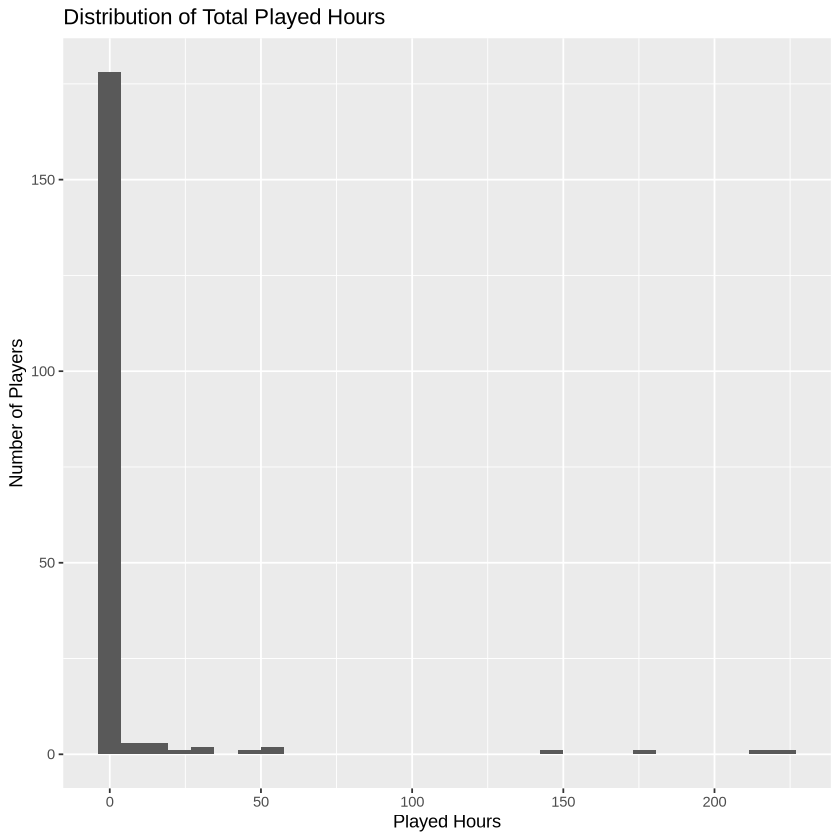

In [44]:
# histogram for play time
ggplot(players_tidy, aes(x = played_hours)) +
  geom_histogram(bins = 30) +
  labs(title = "Distribution of Total Played Hours",
       x = "Played Hours",
       y = "Number of Players")

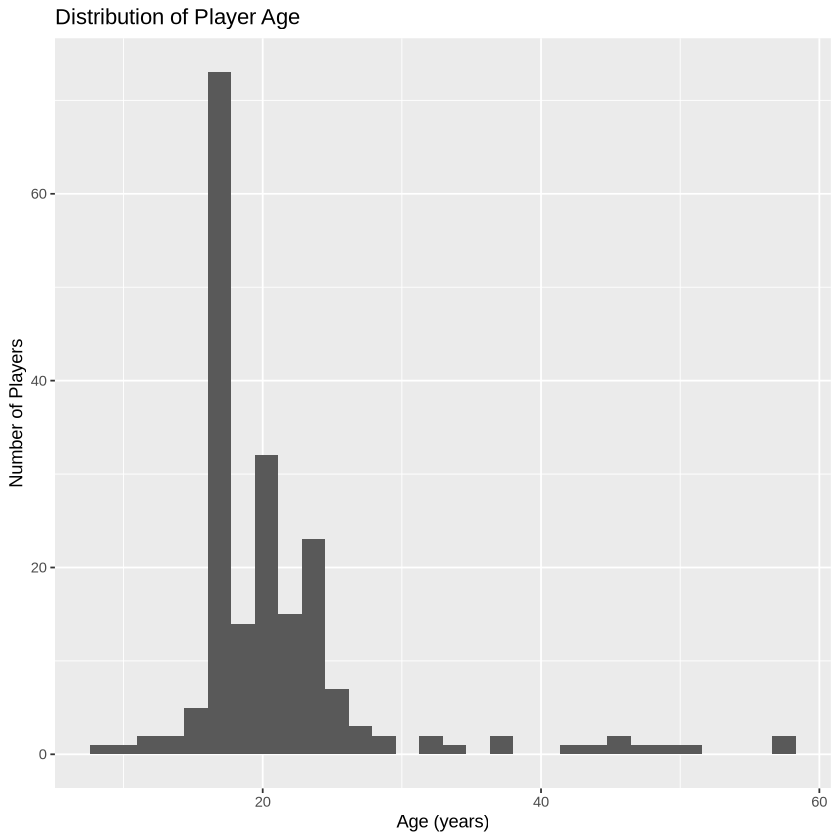

In [48]:
# histogram for age
ggplot(players_tidy, aes(x = Age)) +
  geom_histogram(bins = 30) +
  labs(title = "Distribution of Player Age",
       x = "Age (years)",
       y = "Number of Players")

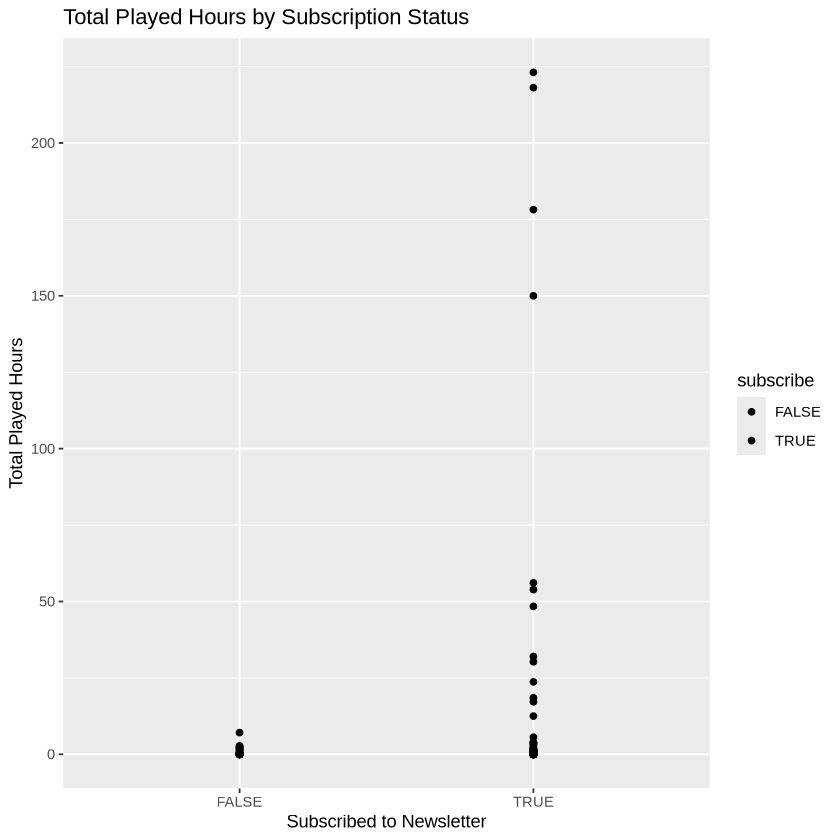

In [49]:
# scatterplot for subscribed vs not subscribed
ggplot(players_tidy, aes(x = subscribe, y = played_hours, fill = subscribe)) +
  geom_point() +
  labs(title = "Total Played Hours by Subscription Status",
       x = "Subscribed to Newsletter",
       y = "Total Played Hours")

#### Insights Gained from the Plots

- Play time is highly skewed and there are mostly people that play for a little time. This indicates that it is necessary to scale and center the explanatory variables such as played_hours. Also, there are a few people that log very high play times, and those people are prime targets to get this project to. It also means that fixing early game experiences can result in the cluster of people at the left of the skew playing more. 
- Age is slightly right skewed but mostly around the 20s. This affects how the group can plan their engagement strategies or newsletter marketings. 

## (4) Methods and Plan



#### Method
To answer the question, "Can player age and total play time predict whether a player subscribes to the newsletter?", we will use knn classification. The response variable will be newsletter subscription (yes/no), and the explanatory variables will be age and total play time. We will use knn classification because it doesn't expect a relationship between the explanatory variables like linear regression models do. 
#### Assumptions
- Players with close age and/or total play time have similar subscription outcomes.
#### Limitations
- The outliers in playing time may distort distances and mess with the model.
- Scaling the variables is necessary to properly predict the outcome
#### Comparing values
1. Select age, play time, and subscription out of the entire dataset.
2. Removing players with any missing values.
3. Center and scale age and play time.
4. Split the data to 70% training data and 30% testing data.
5. Perform a 10 fold cross validation and tune k with workflow.
6. Select the best k and fit the model to the training dataset.
7. Evaluate on the testing data.